# **Notebook Prerequisites**

In [ ]:
!pip install -U fastai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from fastai.vision.all import *


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = 'gdrive/My Drive/Colab Notebooks/'
base_dir = root_dir + 'ball_class'
path=Path(base_dir)

Mounted at /content/gdrive


In [ ]:

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

# **Data Preprocessing and Augmentation**



*   Random Splitting of the dataset (20% for Validation)
*   Resizing the images to size 200x200.
*   Applying default augmentation to our dataset



In [ ]:
fields = DataBlock(blocks=(ImageBlock, CategoryBlock),
   get_items=get_image_files,
   get_y=parent_label,
  splitter=RandomSplitter(valid_pct=0.2, seed=42),
   item_tfms=Resize((200,200)),
   batch_tfms=aug_transforms()
  )

In [ ]:
Path = '/content/gdrive/MyDrive/Stroke_classification_final'

dls = fields.dataloaders(Path)

In [ ]:
dls.vocab

['Haemorrhagic', 'Ischemic']

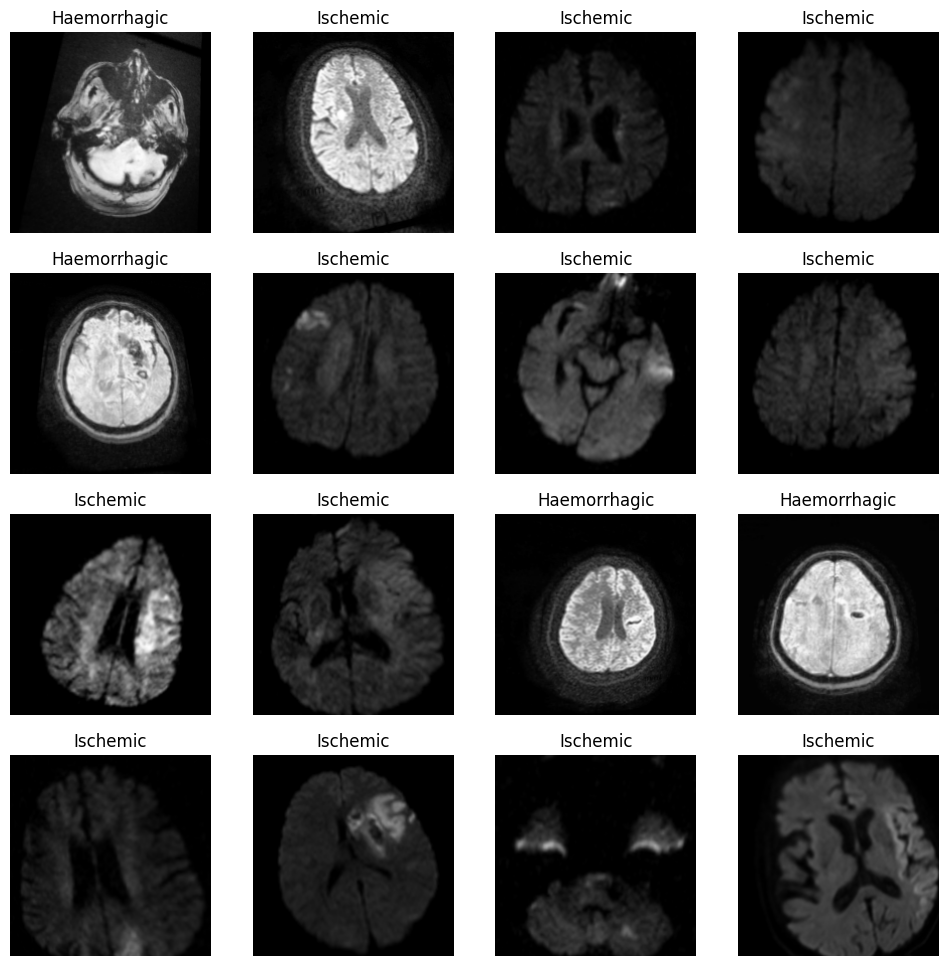

In [ ]:
dls.train.show_batch(max_n=16, nrows=4)

# **Training**

We will be training and comparing 4 different model architectures


1.   ResNet
2.   DenseNet
3.   Squeezenet
4.   AlexNet



## **ResNet**

Residual Networks were introduced in the year 2015 to overcome the problem of Vanishing Gradients. **Residual Blocks** are used in this network to apply the technique of *skip connections*. The advantage of adding this type of skip connection is that if any layer hurt the performance of architecture then it will be skipped by regularization.


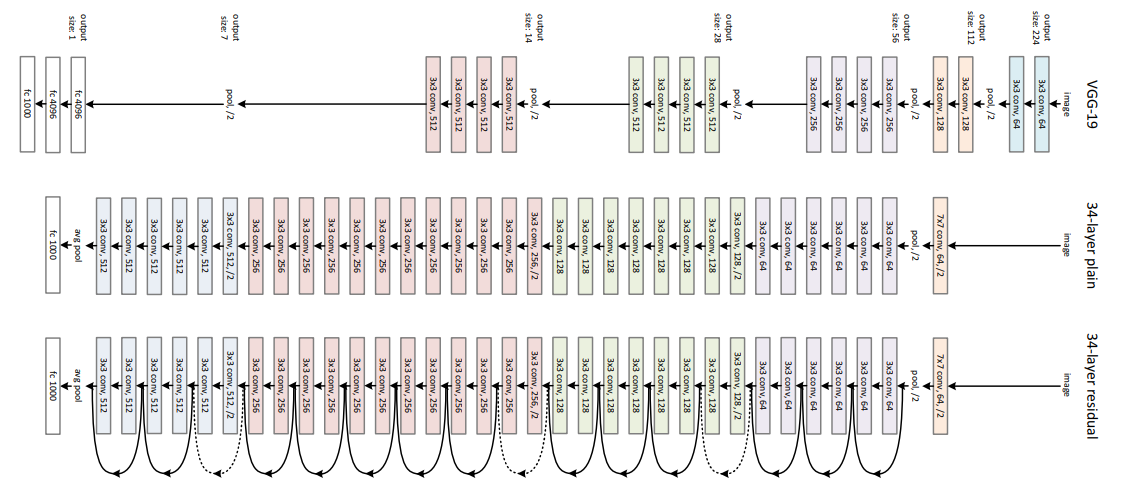


In [ ]:
learn_resent = cnn_learner(dls, resnet101, metrics=error_rate)

/usr/local/lib/python3.9/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe222

In [ ]:
learn_resent.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.725906,0.766442,0.202703,00:24
1,0.425695,0.970865,0.148649,00:06
2,0.300413,1.081257,0.148649,00:08
3,0.234883,0.983132,0.135135,00:07
4,0.203620,0.752742,0.135135,00:05


**Finetuning the baseline model**

Next, we can unfreeze all the trainable parameters from the model and continue its training.

The model already performs well and now, as we unfreeze the bottom layers that have been pre-trained with a large number of general images to detect common shapes and patterns, all weights are mostly adjusted. We should now train with much lower learning rates.

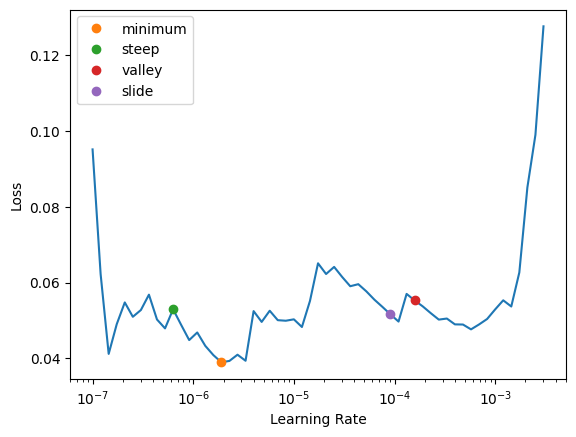

In [ ]:
learn_resent.unfreeze()
lrs = learn_resent.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [ ]:
lrs

SuggestedLRs(minimum=1.9054607491852948e-07, steep=6.309573450380412e-07, valley=0.00015848931798245758, slide=9.120108734350652e-05)

In [ ]:
learn_resent.fit_one_cycle(10,slice(lrs.minimum,lrs.slide))

epoch,train_loss,valid_loss,error_rate,time
0,0.034895,0.612339,0.135135,00:09
1,0.019673,0.529657,0.135135,00:06
2,0.044201,0.447303,0.121622,00:06
3,0.046116,0.420772,0.121622,00:06
4,0.052440,0.406878,0.094595,00:07
5,0.044965,0.364443,0.081081,00:06
6,0.038987,0.315771,0.054054,00:06
7,0.039701,0.286445,0.054054,00:06
8,0.034920,0.277958,0.054054,00:07
9,0.034056,0.269686,0.054054,00:07


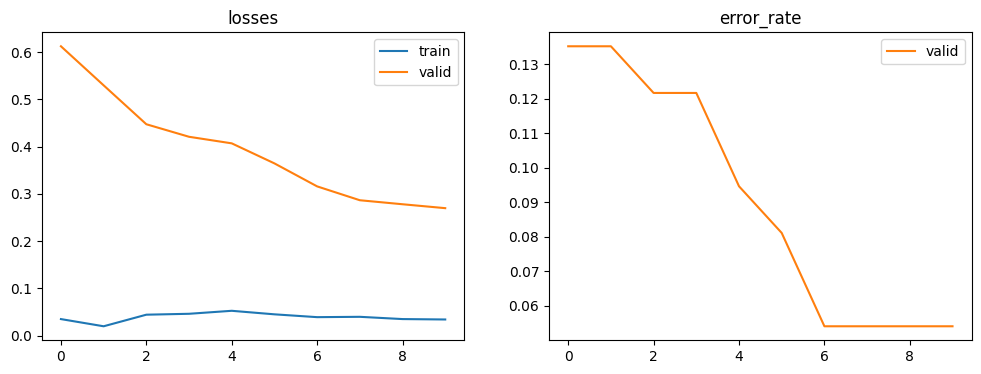

In [ ]:
learn_resent.recorder.plot_metrics()



## **DenseNet**

So dense net is densely connected-convolutional networks. It is very similar to a ResNet with some-fundamental differences. ResNet is using an additive method that means they take a previous output as an input for a future layer, & in DenseNet takes all previous output as an input for a future layer as shown in the above image.

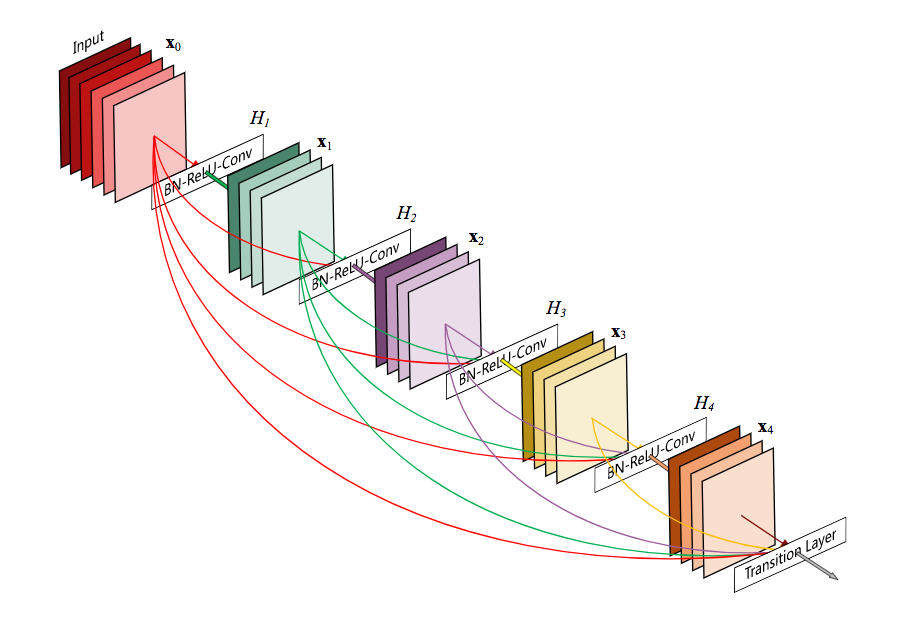


In [ ]:
learn_densenet = cnn_learner(dls, densenet169, metrics=error_rate)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet169_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet169_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet169-b2777c0a.pth" to /root/.cache/torch/hub/checkpoints/densenet169-b2777c0a.pth
100%|██████████| 54.7M/54.7M [00:00<00:00, 92.6MB/s]


In [ ]:
learn_densenet.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,0.732283,0.456699,0.175676,00:06
1,0.394102,0.262623,0.121622,00:05
2,0.263831,0.274470,0.067568,00:07
3,0.194166,0.245259,0.054054,00:08
4,0.161328,0.211848,0.054054,00:07


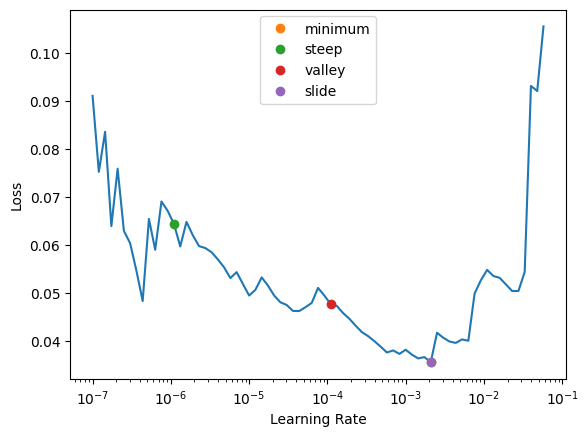

In [ ]:
lrs_densenet = learn_densenet.lr_find(suggest_funcs=(minimum, steep, valley, slide))

**Finetuning the baseline model**

Next, we can unfreeze all the trainable parameters from the model and continue its training.

The model already performs well and now, as we unfreeze the bottom layers that have been pre-trained with a large number of general images to detect common shapes and patterns, all weights are mostly adjusted. We should now train with much lower learning rates.

epoch,train_loss,valid_loss,error_rate,time
0,0.008398,0.178468,0.067568,00:15
1,0.026188,0.168924,0.067568,00:11
2,0.026426,0.153743,0.067568,00:09
3,0.025125,0.119887,0.067568,00:06
4,0.027084,0.104305,0.054054,00:07
5,0.025176,0.114345,0.027027,00:08
6,0.020868,0.128558,0.027027,00:07
7,0.018236,0.143093,0.027027,00:09
8,0.016894,0.147130,0.027027,00:08
9,0.020773,0.142902,0.027027,00:08


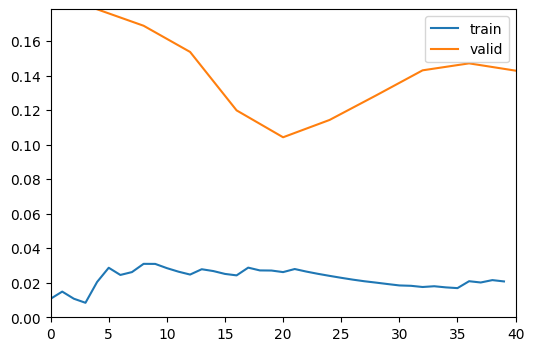

In [ ]:
learn_densenet.unfreeze()
learn_densenet.fit_one_cycle(10,slice(lrs.minimum,lrs.slide),cbs=[ShowGraphCallback()])

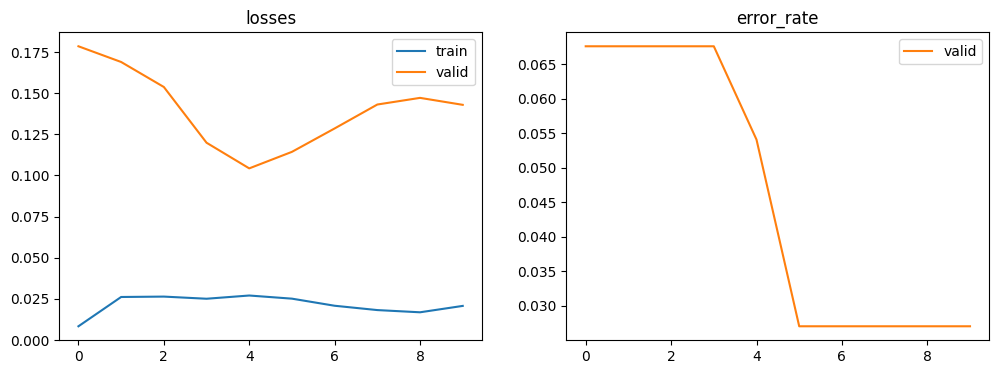

In [ ]:
learn_densenet.recorder.plot_metrics()

## **GoogleNet**

The GoogLeNet architecture is very different from previous state-of-the-art architectures such as AlexNet and ZF-Net. It uses many different kinds of methods such as 1×1 convolution and global average pooling that enables it to create deeper architecture.

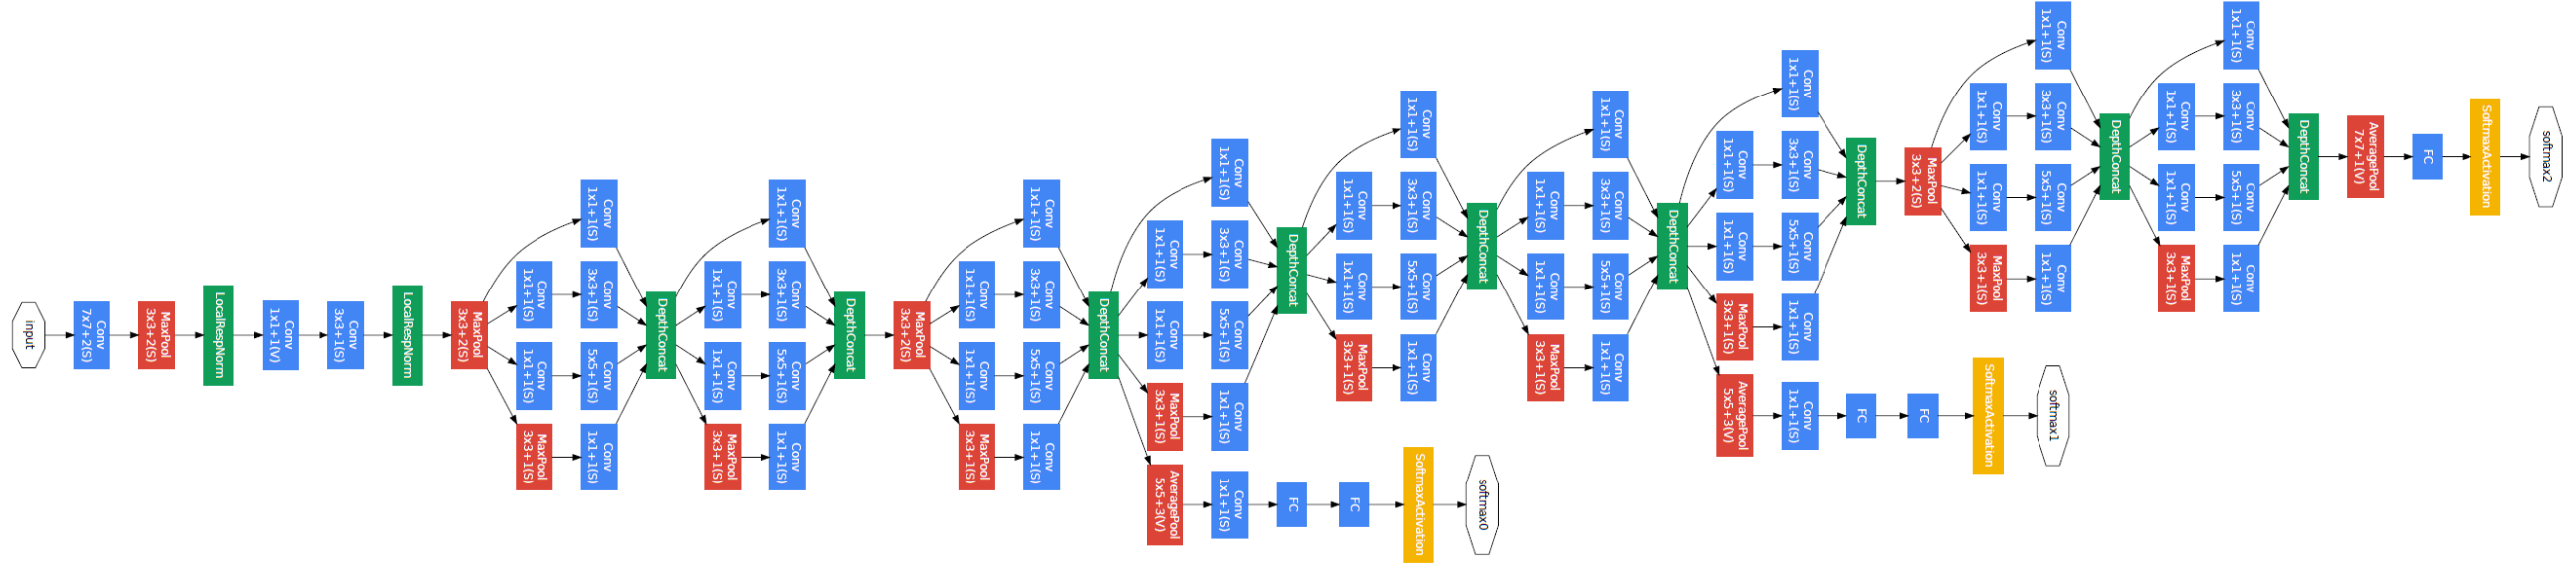



In [ ]:
learn_inception = cnn_learner(dls, googlenet, metrics=error_rate)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.9/dist-packages/fastai/vision/learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or

In [ ]:
learn_inception.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.162995,0.951018,0.459459,00:04
1,0.687053,0.789383,0.189189,00:05
2,0.466494,0.517564,0.121622,00:04
3,0.366704,0.365790,0.108108,00:04
4,0.289895,0.265155,0.054054,00:06


**Finetuning the baseline model**

Next, we can unfreeze all the trainable parameters from the model and continue its training.

The model already performs well and now, as we unfreeze the bottom layers that have been pre-trained with a large number of general images to detect common shapes and patterns, all weights are mostly adjusted. We should now train with much lower learning rates.

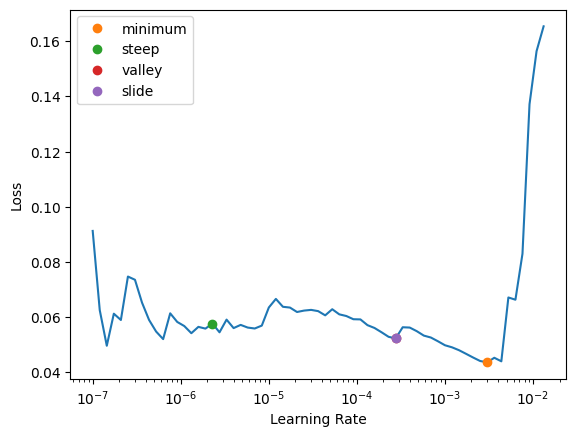

In [ ]:
learn_inception.unfreeze()
lrs = learn_inception.lr_find(suggest_funcs=(minimum, steep, valley, slide))

epoch,train_loss,valid_loss,error_rate,time
0,0.067256,0.309870,0.054054,00:04
1,0.065662,0.468366,0.094595,00:05
2,0.053348,0.631338,0.040541,00:04
3,0.045795,0.754385,0.067568,00:04
4,0.035888,0.099786,0.027027,00:07
5,0.045749,0.062681,0.040541,00:04
6,0.042503,0.213060,0.040541,00:05
7,0.043668,0.164291,0.040541,00:05
8,0.038110,0.099508,0.027027,00:04
9,0.033874,0.087336,0.027027,00:05


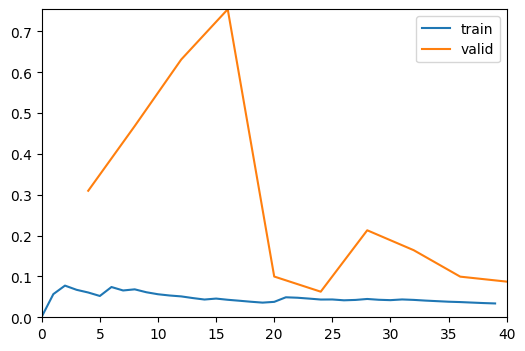

In [ ]:
learn_inception.fit_one_cycle(10,slice(lrs.minimum,lrs.slide),cbs=[ShowGraphCallback()])

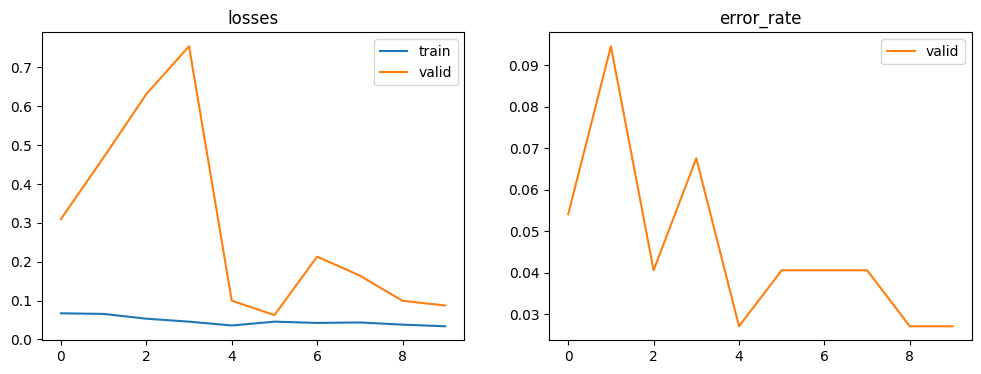

In [ ]:
learn_inception.recorder.plot_metrics()

## **AlexNet**

The Alexnet has eight layers with learnable parameters. The model consists of five layers with a combination of max pooling followed by 3 fully connected layers and they use Relu activation in each of these layers except the output layer.

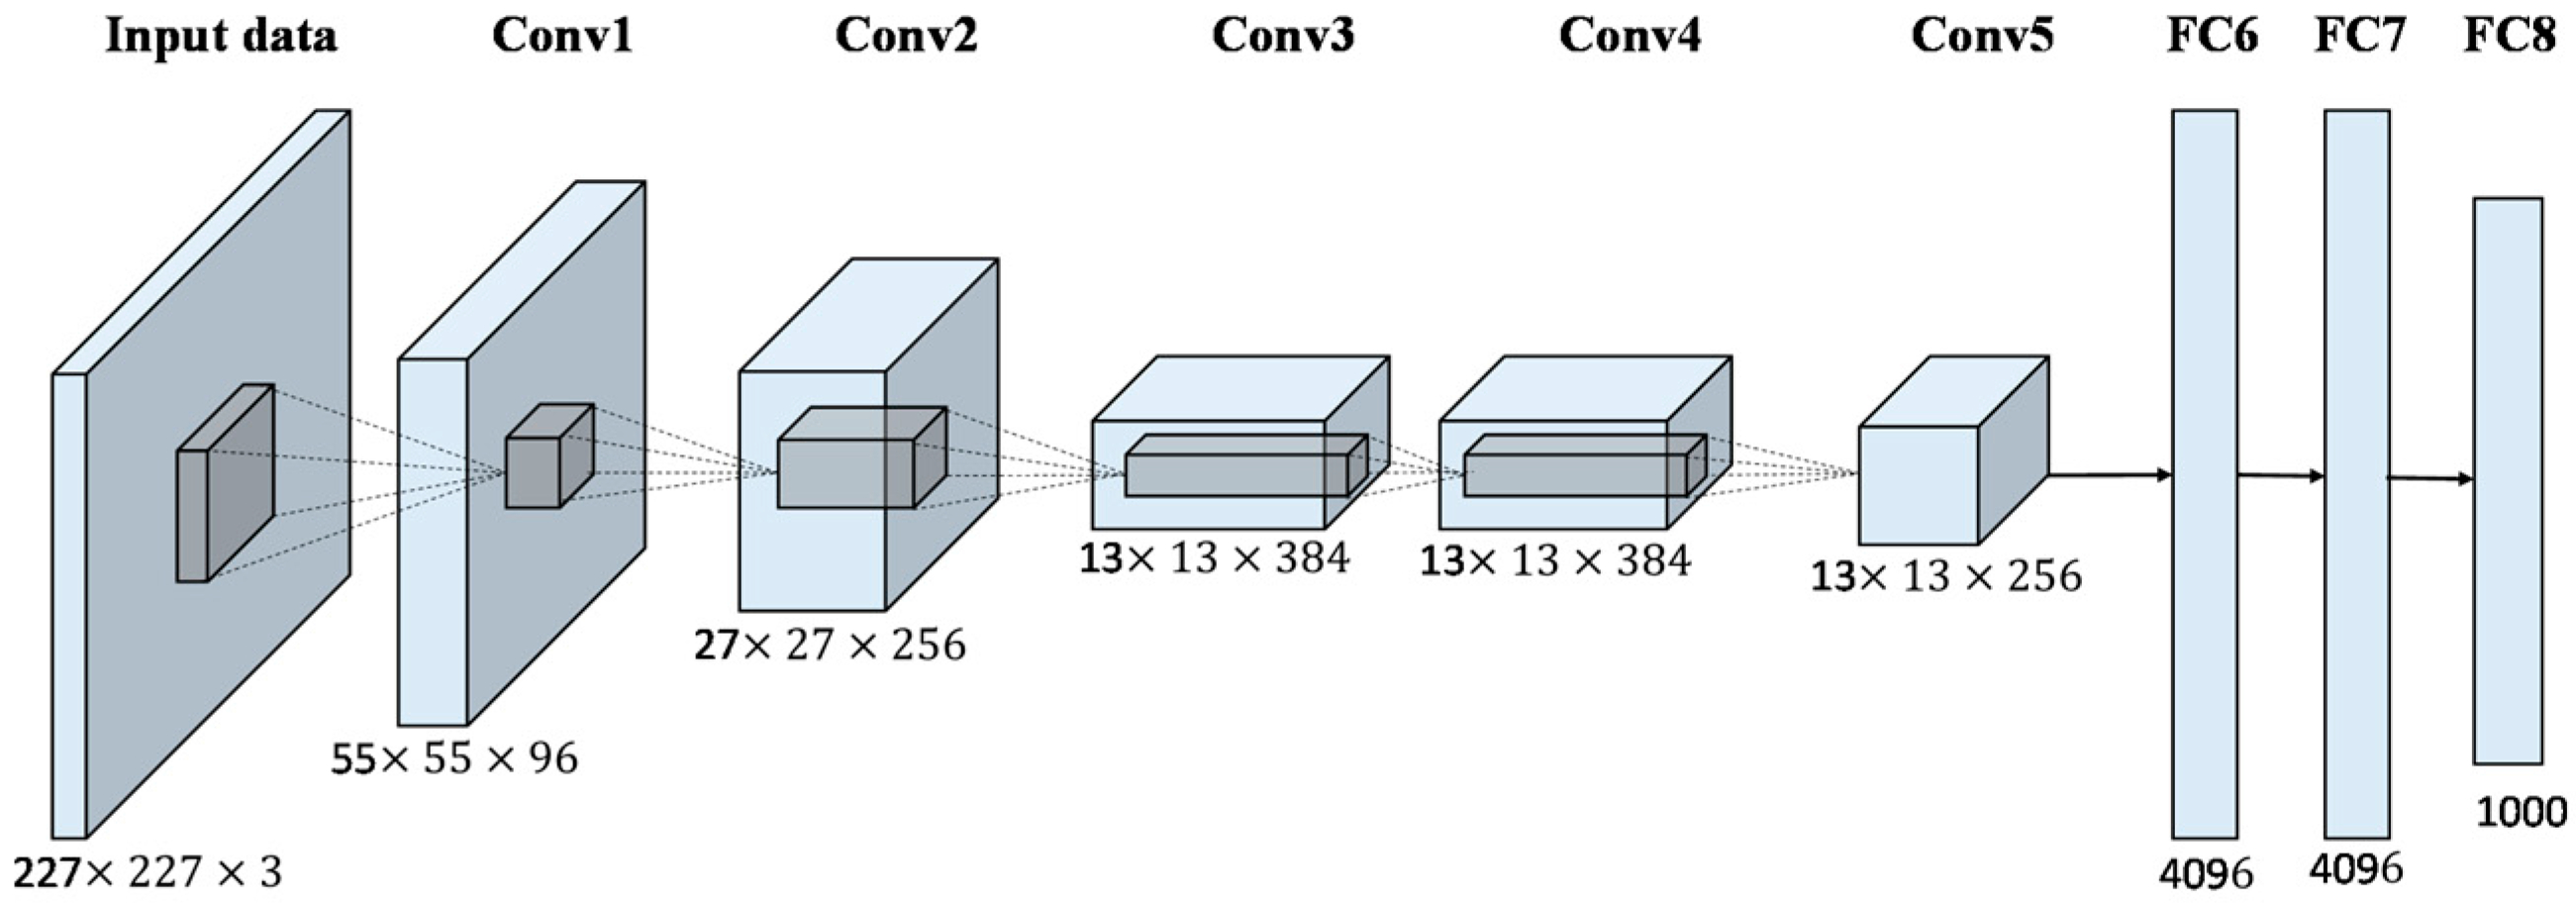

In [ ]:
learn_alexnet = cnn_learner(dls, alexnet,  metrics=error_rate)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:03<00:00, 62.0MB/s]


In [ ]:
learn_alexnet.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.890424,1.699388,0.594595,00:04
1,1.119304,1.413851,0.405405,00:05
2,0.813426,0.931989,0.162162,00:03
3,0.669747,0.669918,0.108108,00:04
4,0.560937,0.532968,0.108108,00:05


**Finetuning the baseline model**

Next, we can unfreeze all the trainable parameters from the model and continue its training.

The model already performs well and now, as we unfreeze the bottom layers that have been pre-trained with a large number of general images to detect common shapes and patterns, all weights are mostly adjusted. We should now train with much lower learning rates.

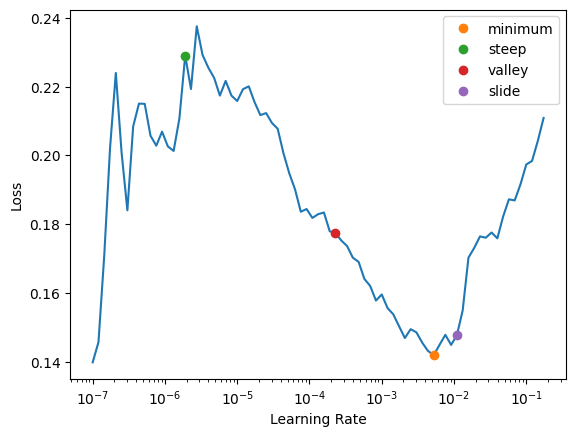

In [ ]:
learn_alexnet.unfreeze()
lr_alexnet = learn_alexnet.lr_find(suggest_funcs=(minimum, steep, valley, slide))

epoch,train_loss,valid_loss,error_rate,time
0,0.115058,0.607391,0.108108,00:04
1,0.136202,0.943227,0.081081,00:05
2,0.276129,5.404011,0.121622,00:04
3,0.333794,1.628163,0.108108,00:03
4,0.280838,0.321086,0.040541,00:05
5,0.230665,0.059760,0.040541,00:03
6,0.203404,0.133618,0.054054,00:04
7,0.176955,0.121482,0.040541,00:05
8,0.157433,0.120657,0.040541,00:04
9,0.139286,0.144976,0.040541,00:04


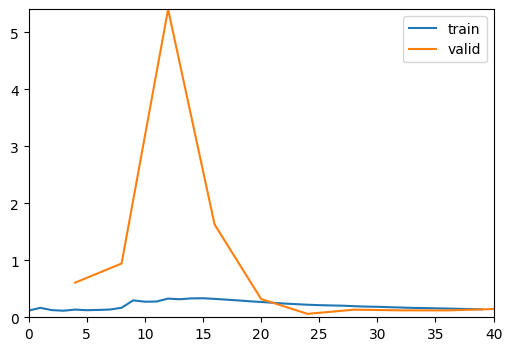

In [ ]:
learn_alexnet.fit_one_cycle(10,slice(lr_alexnet.minimum,lr_alexnet.slide),cbs=[ShowGraphCallback()])

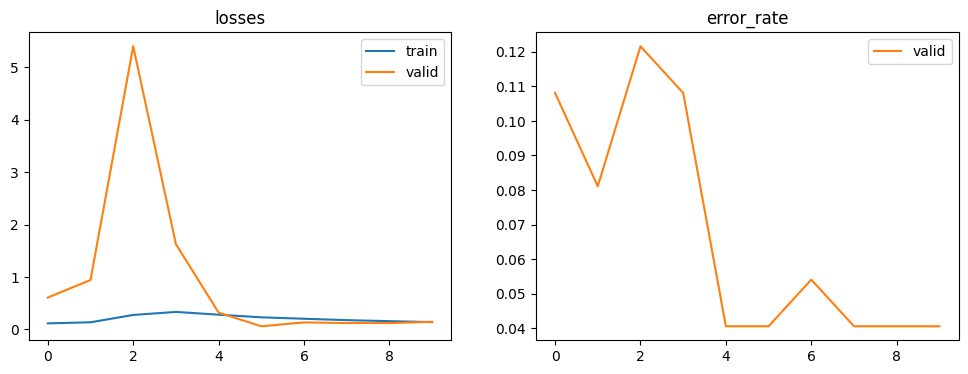

In [ ]:
learn_alexnet.recorder.plot_metrics()

# **Model Evaluation and Accuracy**

## Classification Report

In [ ]:
interp_res = ClassificationInterpretation.from_learner(learn_resent)
interp_den = ClassificationInterpretation.from_learner(learn_densenet)
interp_inception = ClassificationInterpretation.from_learner(learn_inception)
interp_alexnet = ClassificationInterpretation.from_learner(learn_alexnet)

In [ ]:
print("ResNet Classification report\n")
interp_res.print_classification_report()
print("-------------------------------------------------------")

print("DenseNet Classification report\n")
interp_den.print_classification_report()
print("-------------------------------------------------------")

print("GoogleNet Classification report\n")
interp_inception.print_classification_report()
print("-------------------------------------------------------")

print("AlexNet Classification report\n")
interp_alexnet.print_classification_report()
print("-------------------------------------------------------")

ResNet Classification report



              precision    recall  f1-score   support

Haemorrhagic       0.89      1.00      0.94        31
    Ischemic       1.00      0.91      0.95        43

    accuracy                           0.95        74
   macro avg       0.94      0.95      0.95        74
weighted avg       0.95      0.95      0.95        74

-------------------------------------------------------
DenseNet Classification report



              precision    recall  f1-score   support

Haemorrhagic       0.94      1.00      0.97        31
    Ischemic       1.00      0.95      0.98        43

    accuracy                           0.97        74
   macro avg       0.97      0.98      0.97        74
weighted avg       0.97      0.97      0.97        74

-------------------------------------------------------
GoogleNet Classification report



              precision    recall  f1-score   support

Haemorrhagic       0.94      1.00      0.97        31
    Ischemic       1.00      0.95      0.98        43

    accuracy                           0.97        74
   macro avg       0.97      0.98      0.97        74
weighted avg       0.97      0.97      0.97        74

-------------------------------------------------------
AlexNet Classification report



              precision    recall  f1-score   support

Haemorrhagic       0.91      1.00      0.95        31
    Ischemic       1.00      0.93      0.96        43

    accuracy                           0.96        74
   macro avg       0.96      0.97      0.96        74
weighted avg       0.96      0.96      0.96        74

-------------------------------------------------------


## Confusion Matrix

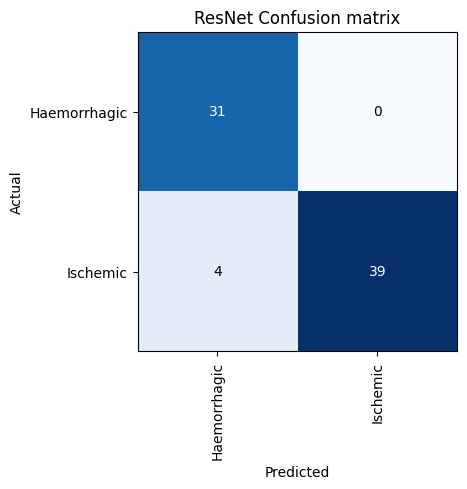

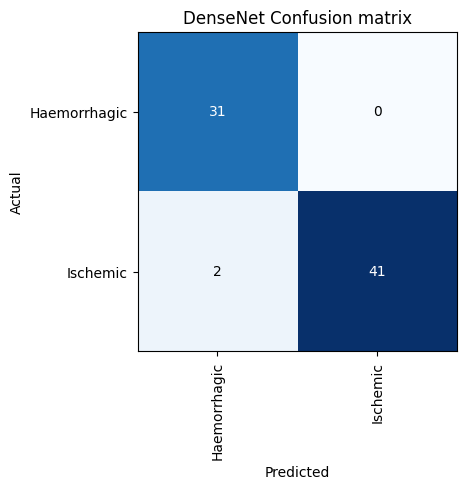

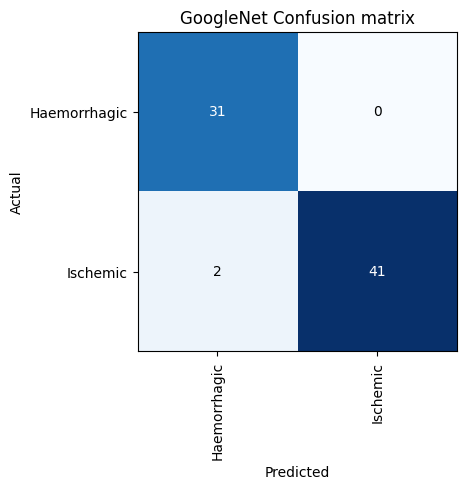

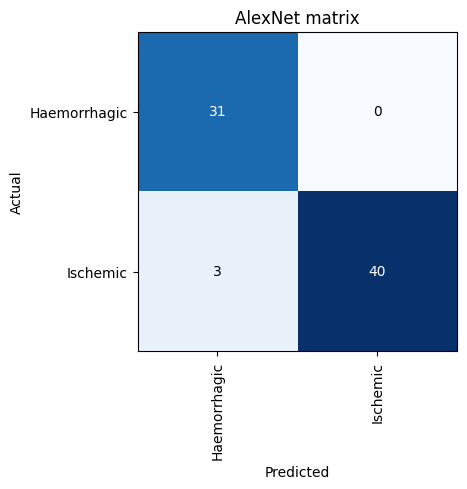

In [ ]:

interp_res.plot_confusion_matrix(title='ResNet Confusion matrix')
interp_den.plot_confusion_matrix(title='DenseNet Confusion matrix')
interp_inception.plot_confusion_matrix(title='GoogleNet Confusion matrix')
interp_alexnet.plot_confusion_matrix(title='AlexNet matrix')


## Accuracy of each models

In [ ]:

def print_acc(learn):
  preds,y, loss = learn.get_preds(with_loss=True)
  acc = accuracy(preds, y)
  return acc

print('ResNet accuracy is {0} %.'.format(print_acc(learn_resent)))
print('DenseNet accuracy is {0} %.'.format(print_acc(learn_densenet)))
print('AlexNet accuracy is {0} %.'.format(print_acc(learn_alexnet)))
print('GoogleNet accuracy is {0} %.'.format(print_acc(learn_inception)))


ResNet accuracy is TensorBase(0.9459) %.


DenseNet accuracy is TensorBase(0.9730) %.


AlexNet accuracy is TensorBase(0.9595) %.


GoogleNet accuracy is TensorBase(0.9730) %.


From the above results we find **DenseNet** and **GoogleNet** Models having the highest accuracy of **97.2 %**

## AUC ROC

In [ ]:
from sklearn.metrics import roc_curve, auc
# probs from log preds
preds,y, loss = learn_densenet.get_preds(with_loss=True)
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)

# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))


ROC area is 0.9909977494373594


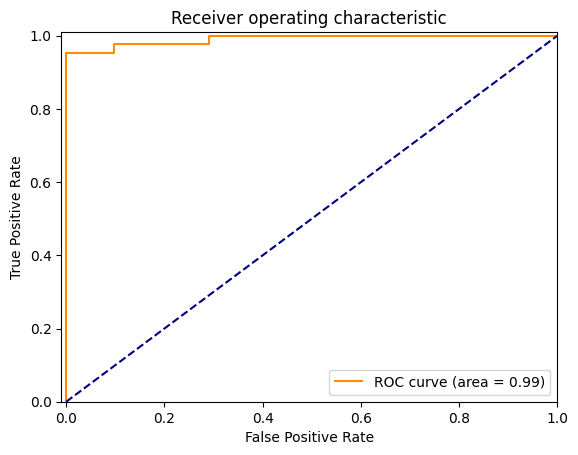

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")